# DEEP LEARNING IN COMPUTER VISION

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---

## Requirements

The experiments should be conducted for 2 data sets selected from the following catalogs: *animals*, *flowers*, *leaves*. The images belonging to these sets should differ in terms of color variability and the size of the objects presented in the images.

## Importing libraries

In [ ]:
from tensorflow.keras.layers import (Dense, Input, Conv2D, Flatten, Reshape, Conv2DTranspose)
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
import cv2, os, warnings, numpy as np, matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

## Setting the working directory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data preparation

In [ ]:
# Loading the dataset
folder_path1 = "/content/drive/MyDrive/son/animals/train"
image_arrays = []
for filename in os.listdir(folder_path1):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
        img_path = os.path.join(folder_path1, filename)
        img = cv2.imread(img_path)  # BGR order
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert to RGB
        img = cv2.resize(img, (224, 224))
        image_arrays.append(img.astype(np.uint8))
x_train = np.stack(image_arrays, axis=0)  # shape: (N, H, W, 3)
print(x_train.shape, x_train.dtype)

folder_path2 = "/content/drive/MyDrive/son/animals/test"
image_arrays = []
for filename in os.listdir(folder_path2):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
        img_path = os.path.join(folder_path2, filename)
        img = cv2.imread(img_path)  # BGR order
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert to RGB
        img = cv2.resize(img, (224, 224))
        image_arrays.append(img.astype(np.uint8))
x_test = np.stack(image_arrays, axis=0)  # shape: (N, H, W, 3)
print(x_test.shape, x_test.dtype)

# Converting an image to grayscale
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

# Entering image dimensions
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
channels = x_train.shape[3]

(600, 224, 224, 3) uint8
(40, 224, 224, 3) uint8


## Colorful input images

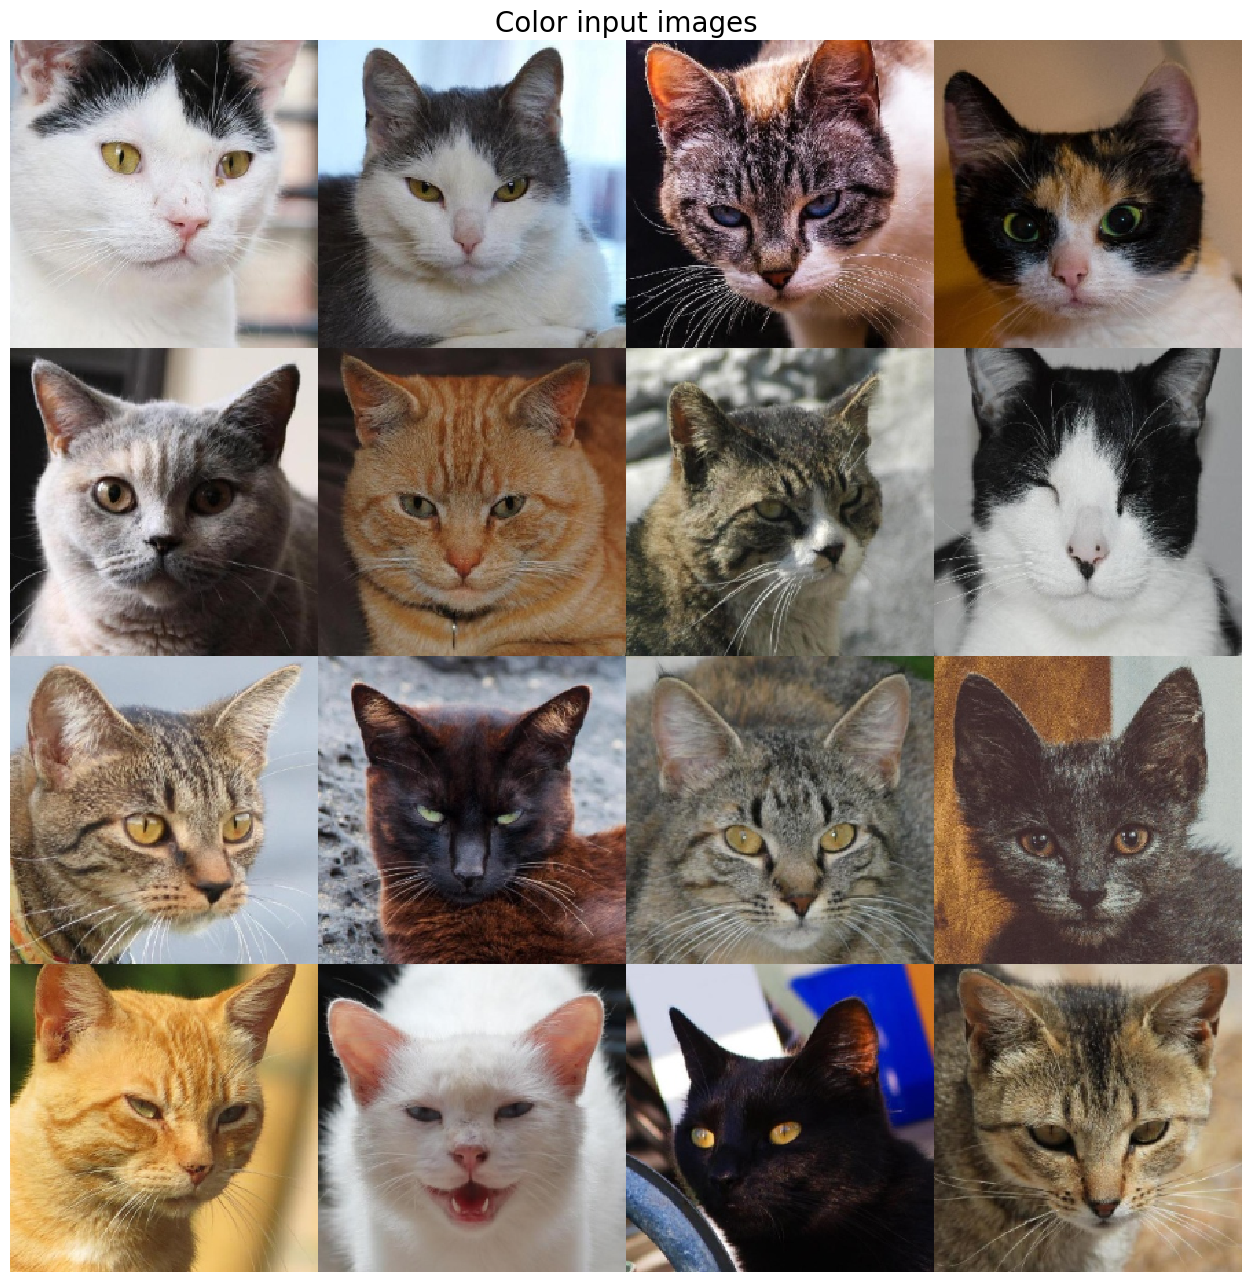

In [ ]:
imgs = x_test[:16]
imgs = imgs.reshape((4, 4, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure(figsize=(16, 16))
plt.axis('off')
plt.title('Color input images', fontsize=20)
plt.imshow(imgs, interpolation='none')
plt.savefig('Color input images.png')
plt.show()

## Conversion of training and test images to grayscale

In [ ]:
x_train_gray = rgb2gray(x_train)
x_test_gray = rgb2gray(x_test)

## Gray input images

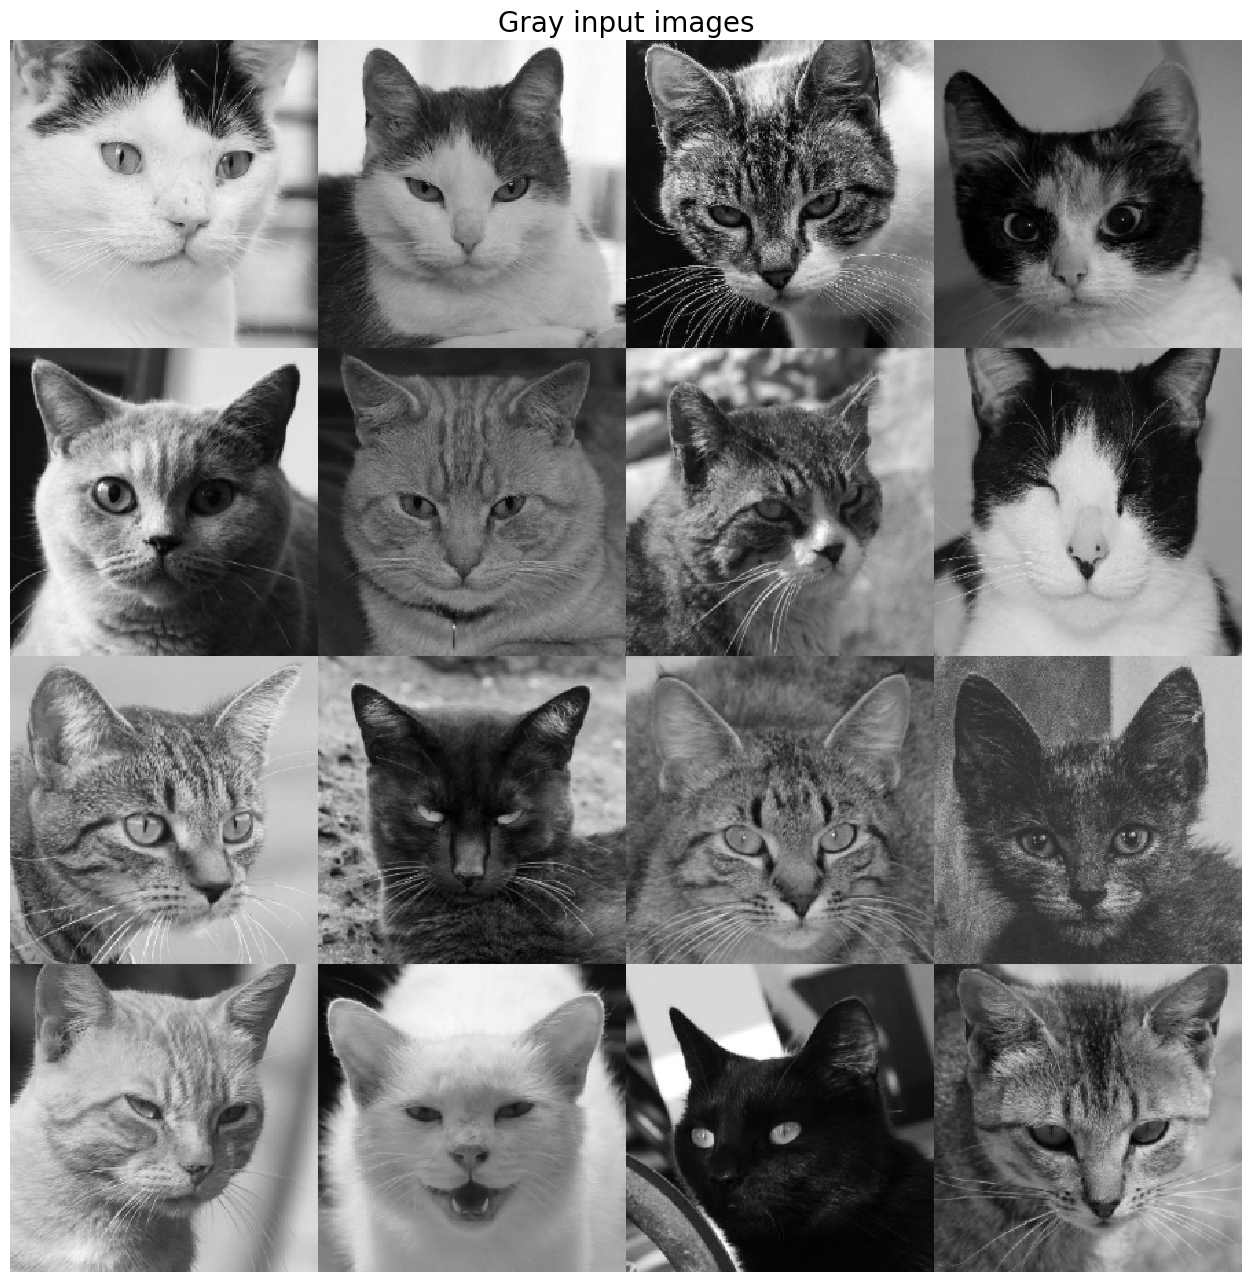

In [ ]:
imgs = x_test_gray[:16]
imgs = imgs.reshape((4, 4, img_rows, img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure(figsize=(16, 16))
plt.axis('off')
plt.title('Gray input images', fontsize=20)
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('Gray input images.png')
plt.show()

## Normalization of color images in the training and test sets

In [ ]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

## Normalization of grayscale images in the training and test sets

In [ ]:
x_train_gray = x_train_gray.astype('float32') / 255
x_test_gray = x_test_gray.astype('float32') / 255

## Changing the shape of color images to row x column x channel

In [ ]:
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)

## Changing the shape of gray images to row x column x channel

In [ ]:
x_train_gray = x_train_gray.reshape(x_train_gray.shape[0], img_rows, img_cols, 1)
x_test_gray = x_test_gray.reshape(x_test_gray.shape[0], img_rows, img_cols, 1)

## Network parameters

In [ ]:
input_shape = (img_rows, img_cols, 1)
batch_size = 8
kernel_size = 3
latent_dim = 256

## Number of CNN layers acting as encoders / decoders and number of filters per layer

In [ ]:
layer_filters = [64, 128, 256]

## Encoder construction

Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 112, 112, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ implicit_vector (Dense)         │ (None, 256)            │    51,380,480 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,750,144 (197.41 MB)

 Trainable params: 51,750,144 (197.41 MB)

 Non-trainable params: 0 (0.00 B)

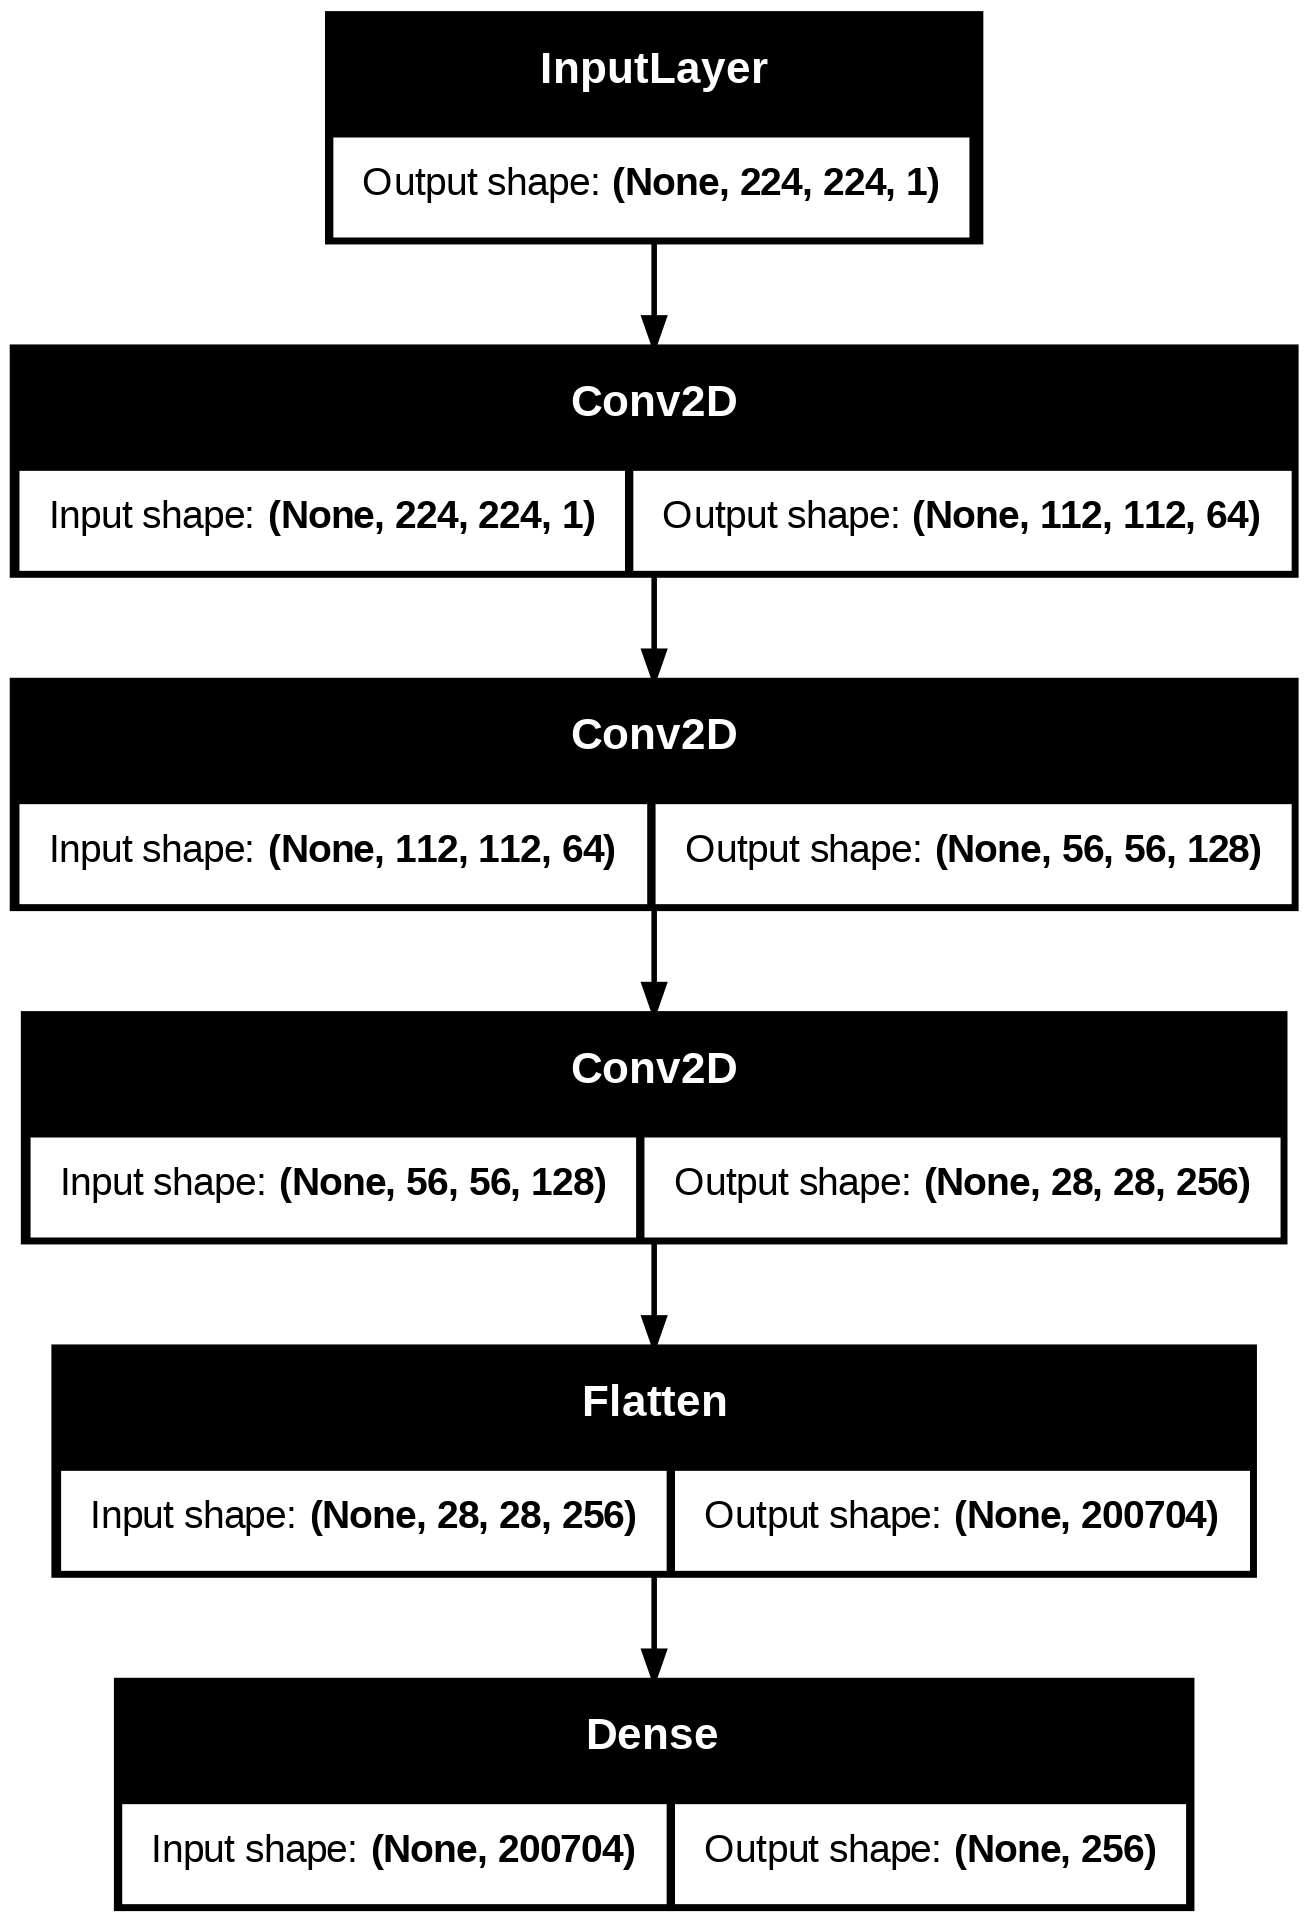

In [ ]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# Conv2D(32)-Conv2D(64) stack
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)
shape = K.int_shape(x)

# Generating an implicit vector
x = Flatten()(x)
latent = Dense(latent_dim, name='implicit_vector')(x)

# Creating an encoder object
encoder = Model(inputs,
                latent,
                name='Encoder')
encoder.summary()
plot_model(encoder, to_file='encoder.png', show_shapes=True)

## Decoder construction

Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 200704)         │    51,580,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 56, 56, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 112, 112, 128)  │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 224, 224, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output                  │ (None, 224, 224, 3)    │         1,731 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,541,571 (200.43 MB)

 Trainable params: 52,541,571 (200.43 MB)

 Non-trainable params: 0 (0.00 B)

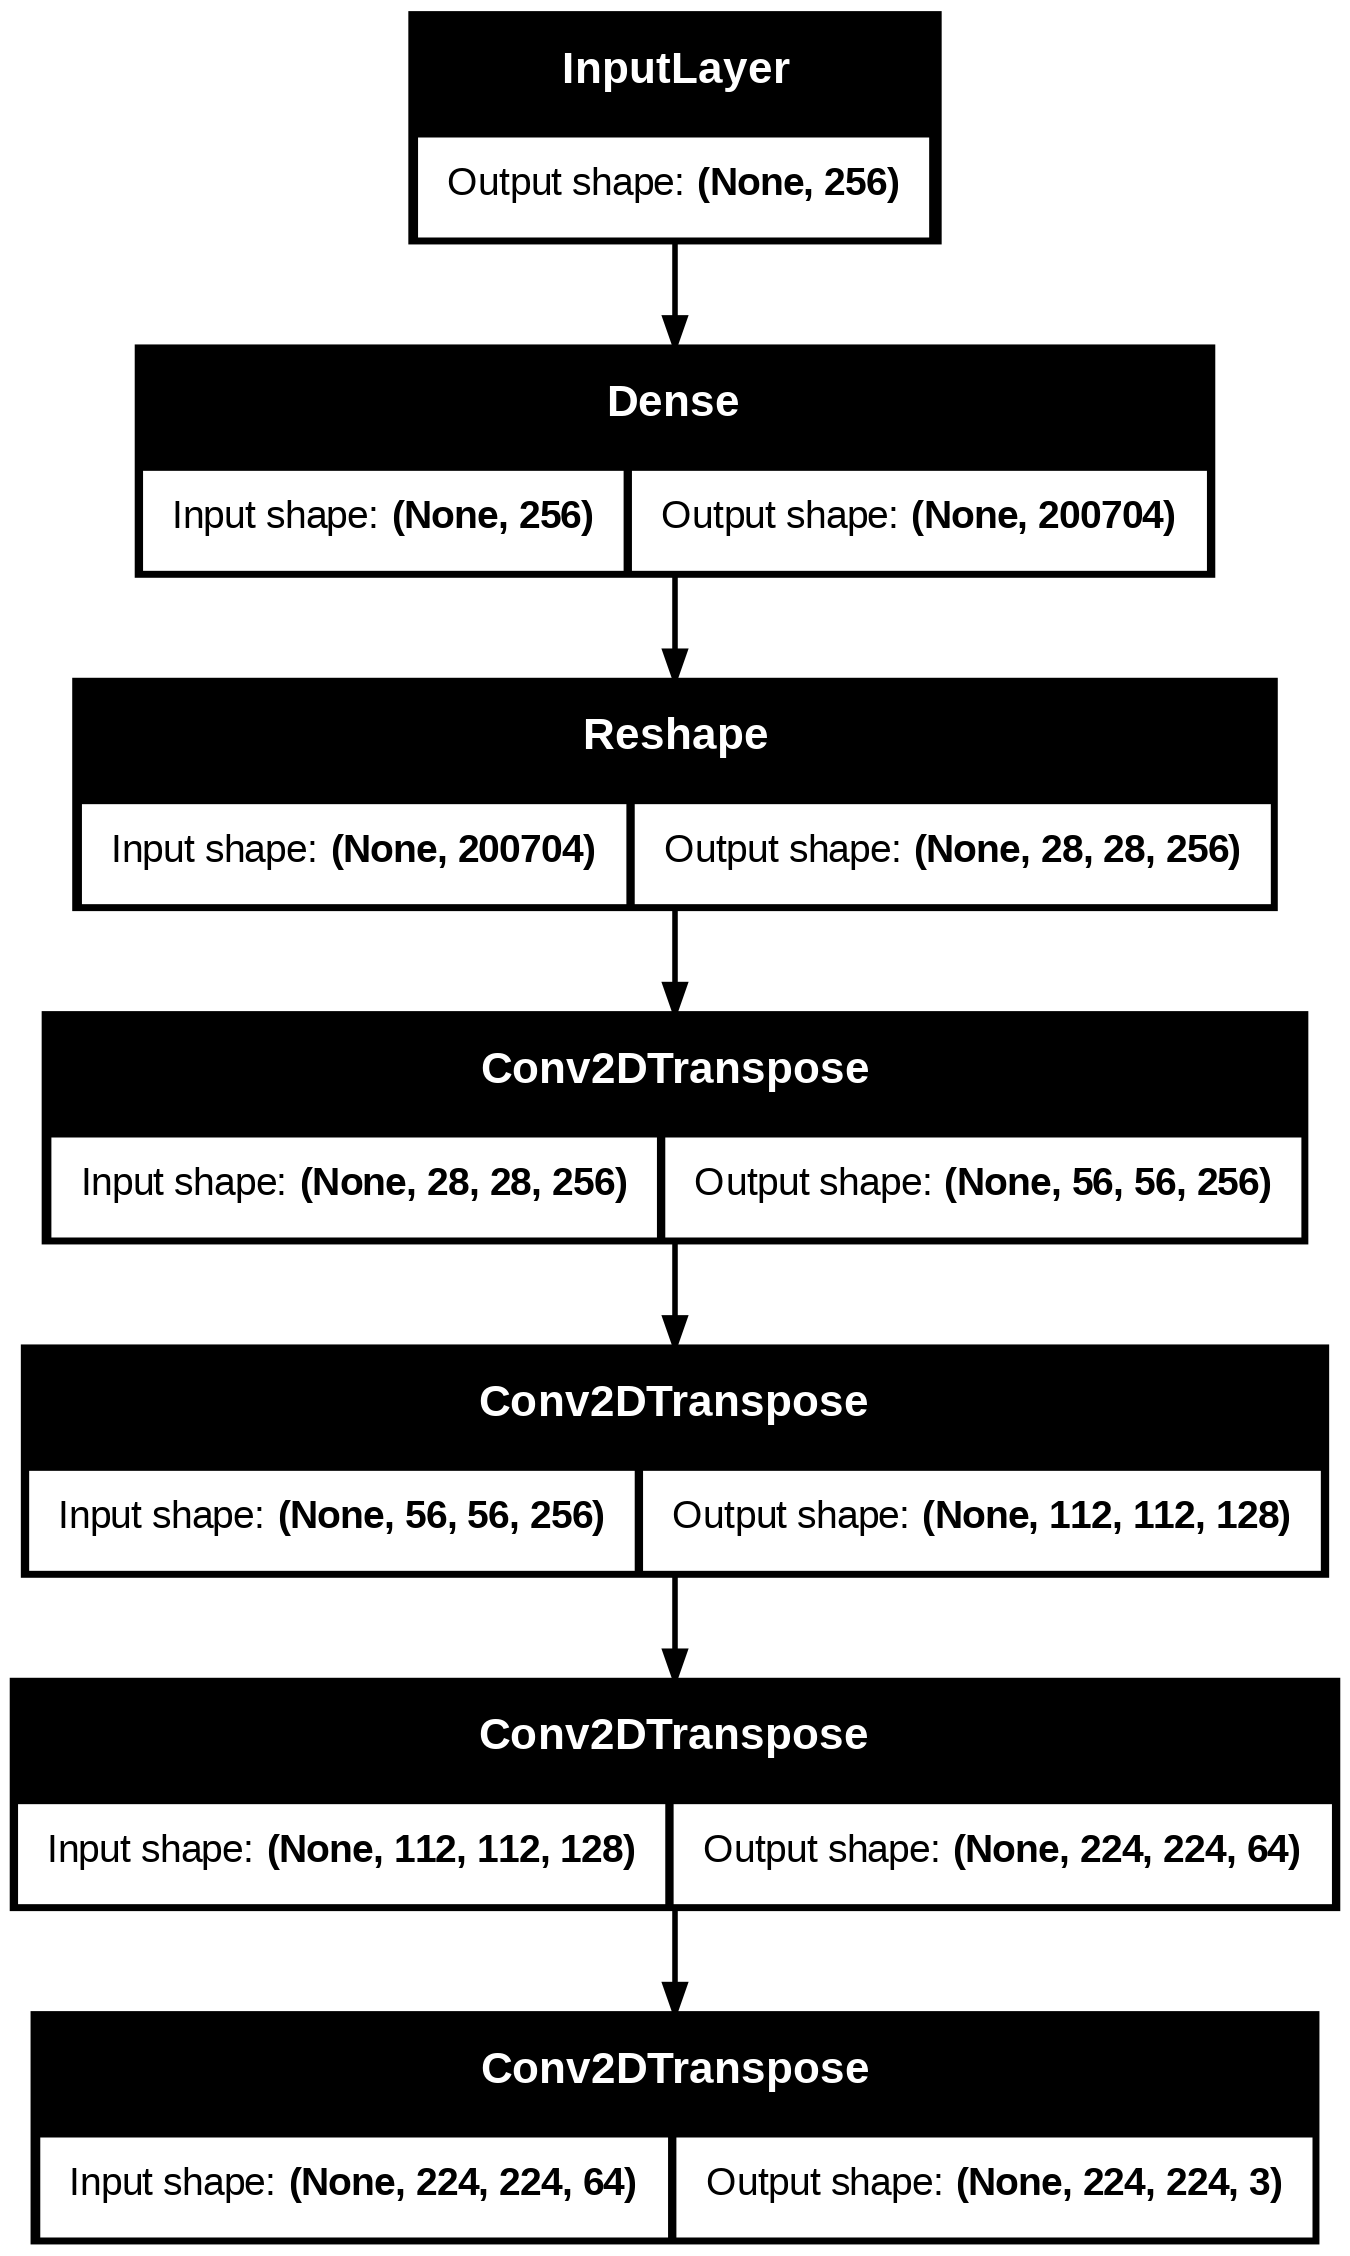

In [ ]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)

# Changing the shape to a form suitable for Conv2D
x = Reshape((shape[1], shape[2], shape[3]))(x)

# Stack of layers Conv2DTranspose(256)-Conv2DTranspose(128)
# -Conv2DTranspose(64)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

# Reconstruction of input signals
outputs = Conv2DTranspose(filters=channels,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# Creating a decoder object
decoder = Model(latent_inputs,
                outputs,
                name='Decoder')
decoder.summary()
plot_model(decoder, to_file='decoder.png', show_shapes=True)

## Autoencoder object = encoder + decoder

Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder (Functional)            │ (None, 256)            │    51,750,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder (Functional)            │ (None, 224, 224, 3)    │    52,541,571 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,291,715 (397.84 MB)

 Trainable params: 104,291,715 (397.84 MB)

 Non-trainable params: 0 (0.00 B)

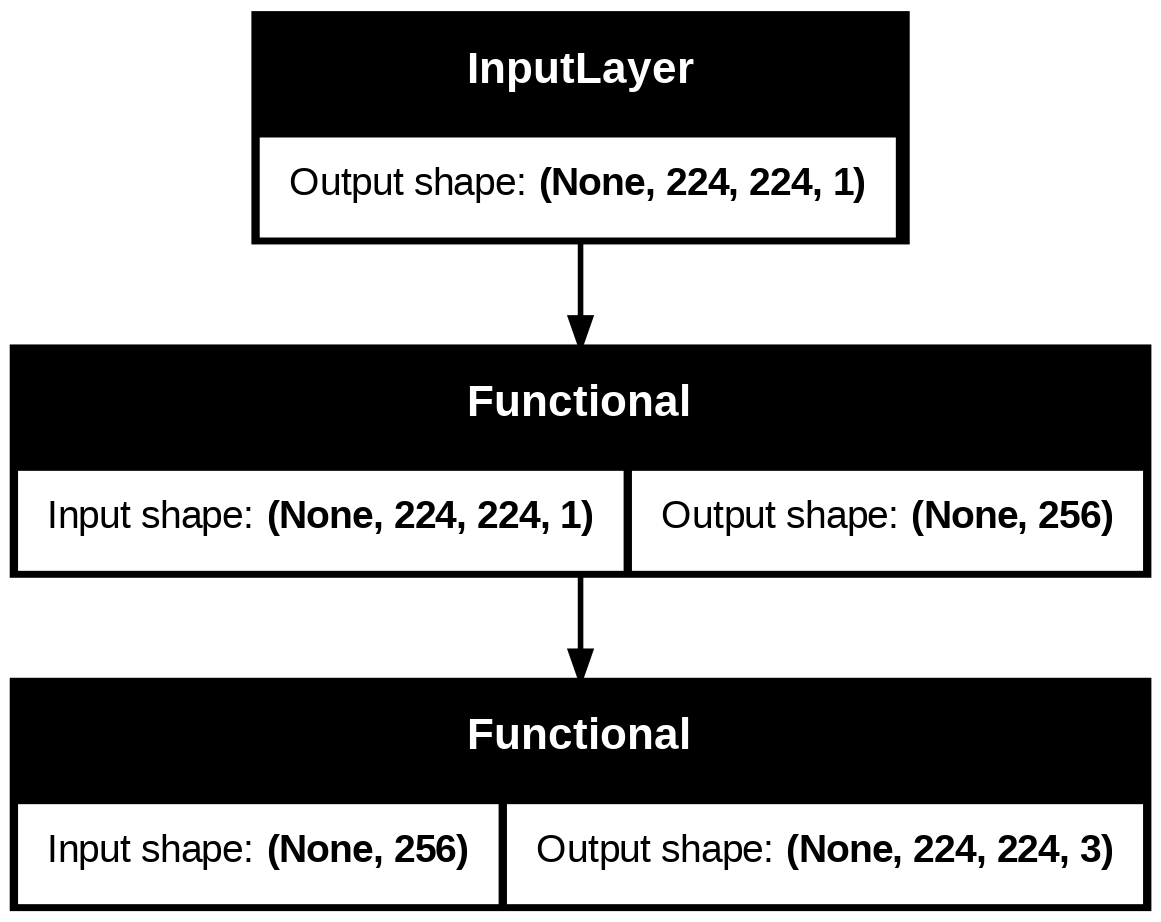

In [ ]:
autoencoder = Model(inputs,
                    decoder(encoder(inputs)),
                    name='Autoencoder')
autoencoder.summary()
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)

## Loss function as mean square error (MSE) and Adam optimizer

In [ ]:
autoencoder.compile(loss='mse', optimizer='adam')

## Training an autoencoding network

In [ ]:
autoencoder.fit(x_train_gray,
                x_train,
                validation_data=(x_test_gray, x_test),
                epochs=50,
                batch_size=batch_size)

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step - loss: 0.0632 - val_loss: 0.0418
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.0356 - val_loss: 0.0315
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 0.0285 - val_loss: 0.0268
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.0247 - val_loss: 0.0251
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 0.0232 - val_loss: 0.0232
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 0.0210 - val_loss: 0.0232
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - loss: 0.0196 - val_loss: 0.0220
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: 0.0191 - val_loss: 0.0212
Epoch 9/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: 0.0176 - val_loss: 0.0205
Epoch 10/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: 0.0159 - val_loss: 0.0211
Epoch 11/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: 0.0153 - val_loss: 0.0204
Epoch 12/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - loss: 0.

## Prediction of results for test data

In [ ]:
x_decoded = autoencoder.predict(x_test_gray)

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 562ms/step


## Displaying the first 16 colored images

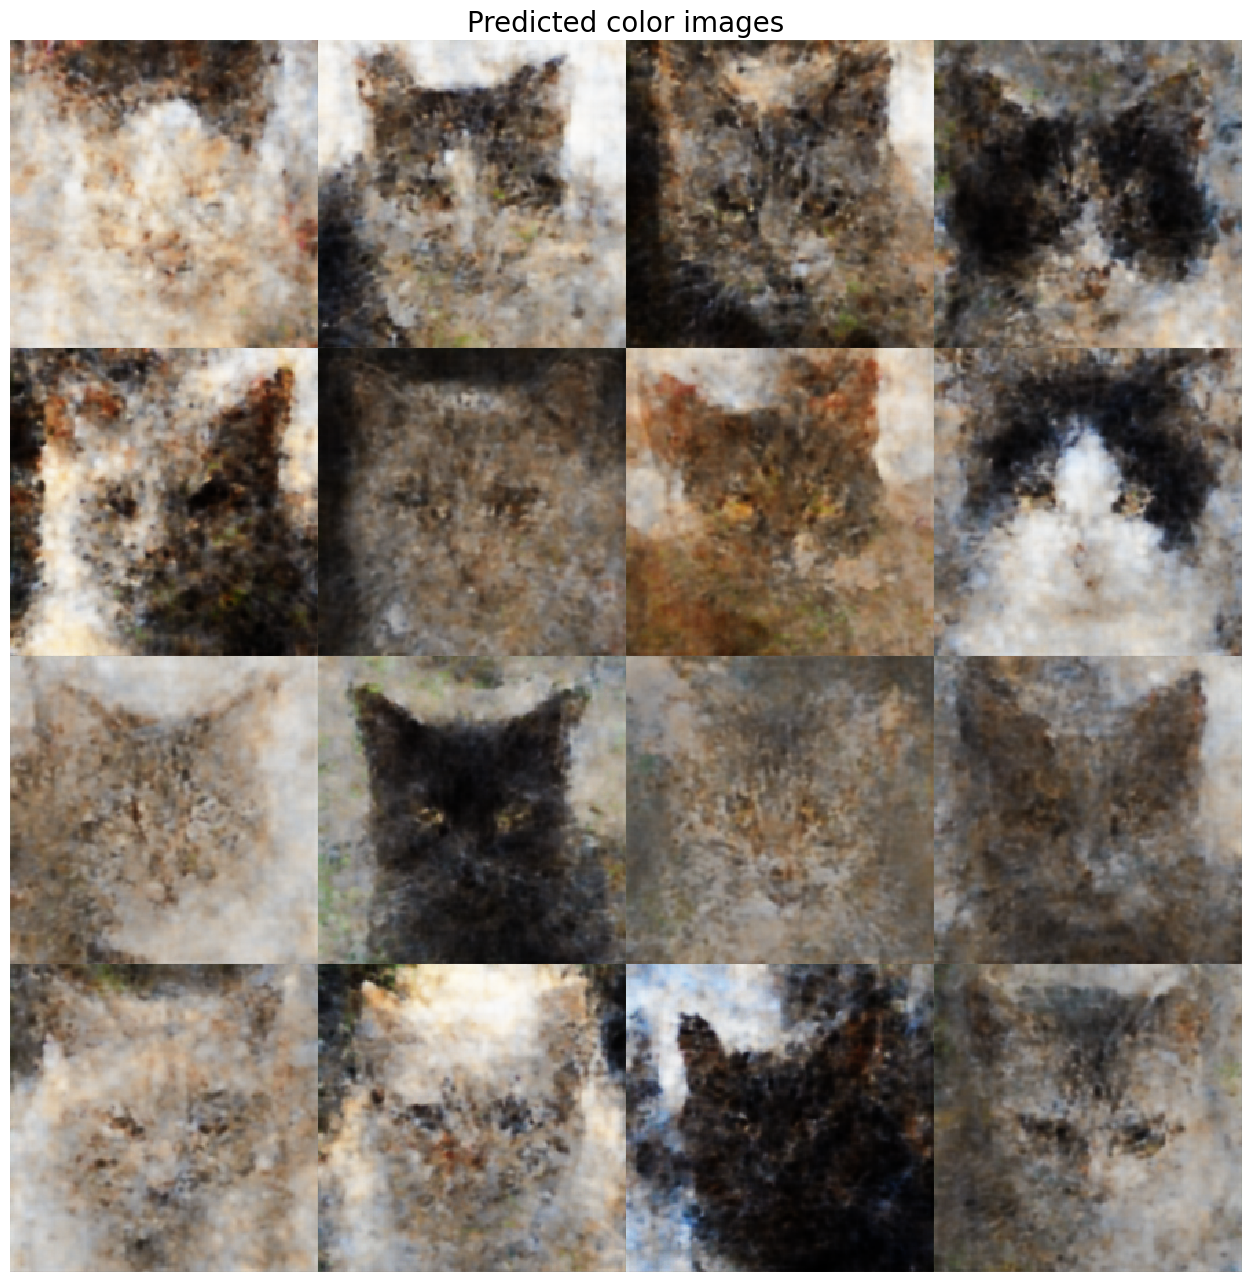

In [ ]:
imgs = x_decoded[:16]
imgs = imgs.reshape((4, 4, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure(figsize=(16, 16))
plt.axis('off')
plt.title('Predicted color images', fontsize=20)
plt.imshow(imgs, interpolation='none')
plt.savefig('Colored_images.png')
plt.show()

## Conclusions

The conclusions should justify the impact of:
- the specificity of the data collection;
- the number of training epochs (e.g., 50, 150)

on the results obtained.

The experimental results demonstrate that both the specificity of the data collection and the number of training epochs significantly influenced the model performance.

Regarding data collection, the dataset used in this experiment was preprocessed and organized in a structured way, which helped the model learn relevant visual features effectively. The specificity of the data, including its quality, consistency, and relevance to the task, contributed to stable training behavior and improved validation performance. This indicates that well-selected and properly prepared data plays a critical role in achieving reliable and accurate results.

Concerning the number of training epochs, the model was trained for 50 epochs, which allowed it to converge and learn meaningful patterns from the data. The training and validation loss curves show that the model achieved good performance without severe overfitting. If the number of epochs were increased (e.g., to 150), the model might learn more complex patterns and potentially improve accuracy; however, it could also increase the risk of overfitting and reduce generalization performance. Conversely, using fewer epochs could lead to underfitting and lower accuracy.

Therefore, the results confirm that both the specificity of the dataset and the choice of an appropriate number of training epochs are crucial factors in determining the effectiveness and reliability of the deep learning model.